In [1]:
import pickle
import yaml
import torch

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "mathptmx",
    'font.size': 20
})

In [2]:
configs = yaml.safe_load(open("config/config.yml")) 
config = configs['sigma']['sigma_01']

In [3]:
with open(f'../results/{config["name"]}.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [4]:
t = data['t']
x = data['x']
y_data = data['y_data']
true = data['true']
x_preds = data['x_preds']
domain = [-1, 1]


In [5]:
def calculate_mean_and_quantile(x_preds):
    x_mean = torch.mean(x_preds, axis=0)
    lower_quantile = torch.quantile(x_preds, 0.05, axis=0)
    upper_quantile = torch.quantile(x_preds, 0.95, axis=0)

    return x_mean, lower_quantile, upper_quantile


def plot_results(config, t, x, true, y_data, x_preds):
    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(x_preds)

    plt.figure()
    plt.plot(x, true, label='true')
    plt.plot(t, y_data, label='data')

    line, = plt.plot(t, x_mean, label='inverse solution')
    # Plot the quantile range as a shaded area
    plt.fill_between(x, lower_quantile, upper_quantile, color=line.get_color(), alpha=0.5, label='90% quantile range')
    #plt.plot(t, A@x_solution.numpy(), label='A @ solution')
    plt.axis([domain[0], domain[1], -0.1, 1.5])
    plt.xlabel('t')
    plt.ylabel('x')

    plt.savefig(f"plots/{config['plot_parameters']['solution_plot']}")


def plot_problem(config_name: str):

    with open(f'../results/{config_name}.pickle', 'rb') as handle:
        data = pickle.load(handle)

    plt.figure()
    plt.plot(data['t'], data['true'],linewidth=0.7)
    plt.plot(data['x'], data['y_data'],linewidth=0.7)

    plt.axis([domain[0], domain[1], -0.5, 1.5])
    plt.savefig(f"../plots/{config_name}_problem.png")

In [10]:
def plot_sigma_subplots(configs, type):

    fig, axs = plt.subplots(2, 4, figsize=(16, 10))
    ii, jj = 0, 0
    with open(f'../results/initial.pickle', 'rb') as handle:
        data = pickle.load(handle)

    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

    axs[ii, jj].plot(data['t'], data['true'],linewidth=0.7)
    axs[ii, jj].plot(data['x'], data['y_data'],linewidth=0.7)

    line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution',linewidth=0.7)
    axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
    
    axs[ii, jj].set_title(f'$\sigma^2= {configs["misc"]["initial"]["sigma_noise"]}^2$')
    jj = jj +1


    for idx, conf in enumerate(configs[type]):
        with open(f'../results/{conf}.pickle', 'rb') as handle:
            data = pickle.load(handle)
        
        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        axs[ii, jj].plot(data['t'], data['true'],linewidth=0.7)
        axs[ii, jj].plot(data['x'], data['y_data'],linewidth=0.7)

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution',linewidth=0.7)
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        axs[ii, jj].set_title(f'$\sigma^2= {configs[type][conf]["sigma_noise"]}^2$')
        jj = jj +1
        if jj >3:
            ii = ii +1
            jj = 0
    plt.tight_layout()



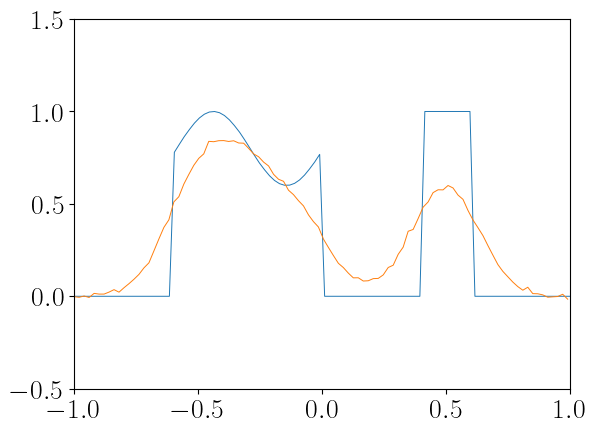

In [11]:
plot_problem('initial')

FileNotFoundError: [Errno 2] No such file or directory: '../results/sigma_03.pickle'

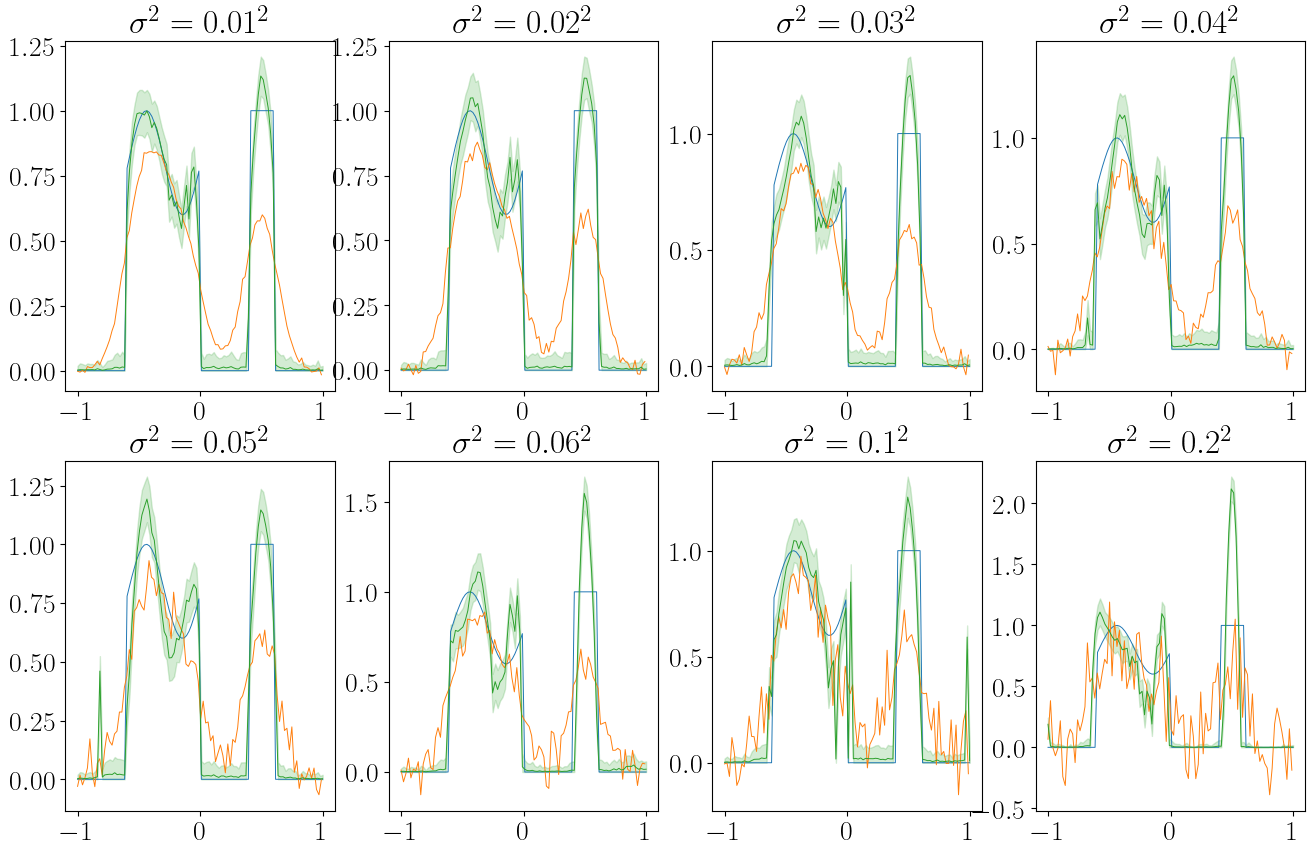

In [12]:
plot_sigma_subplots(configs, 'sigma')

In [13]:
def plot_lr_subplots(configs, type):

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    ii, jj = 0, 0
    with open(f'../results/initial.pickle', 'rb') as handle:
        data = pickle.load(handle)
    '''
    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

    axs[ii, jj].plot(data['t'], data['true'],linewidth=0.7)
    axs[ii, jj].plot(data['x'], data['y_data'],linewidth=0.7)

    line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution',linewidth=0.7)
    axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
    
    axs[ii, jj].set_title(f'$\eta= {configs["misc"]["initial"]["training_parameters"]["learning_rate"]}$')
    jj = jj +1

    '''
    for idx, conf in enumerate(configs[type]):
        with open(f'../results/{conf}.pickle', 'rb') as handle:
            data = pickle.load(handle)
        
        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        axs[ii, jj].plot(data['t'], data['true'],linewidth=0.7)
        axs[ii, jj].plot(data['x'], data['y_data'],linewidth=0.7)

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution',linewidth=0.7)
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        axs[ii, jj].set_title(f'$\eta= {configs[type][conf]["training_parameters"]["learning_rate"]}$')
        jj = jj +1
        if jj >1:
            ii = ii +1
            jj = 0
    plt.tight_layout()



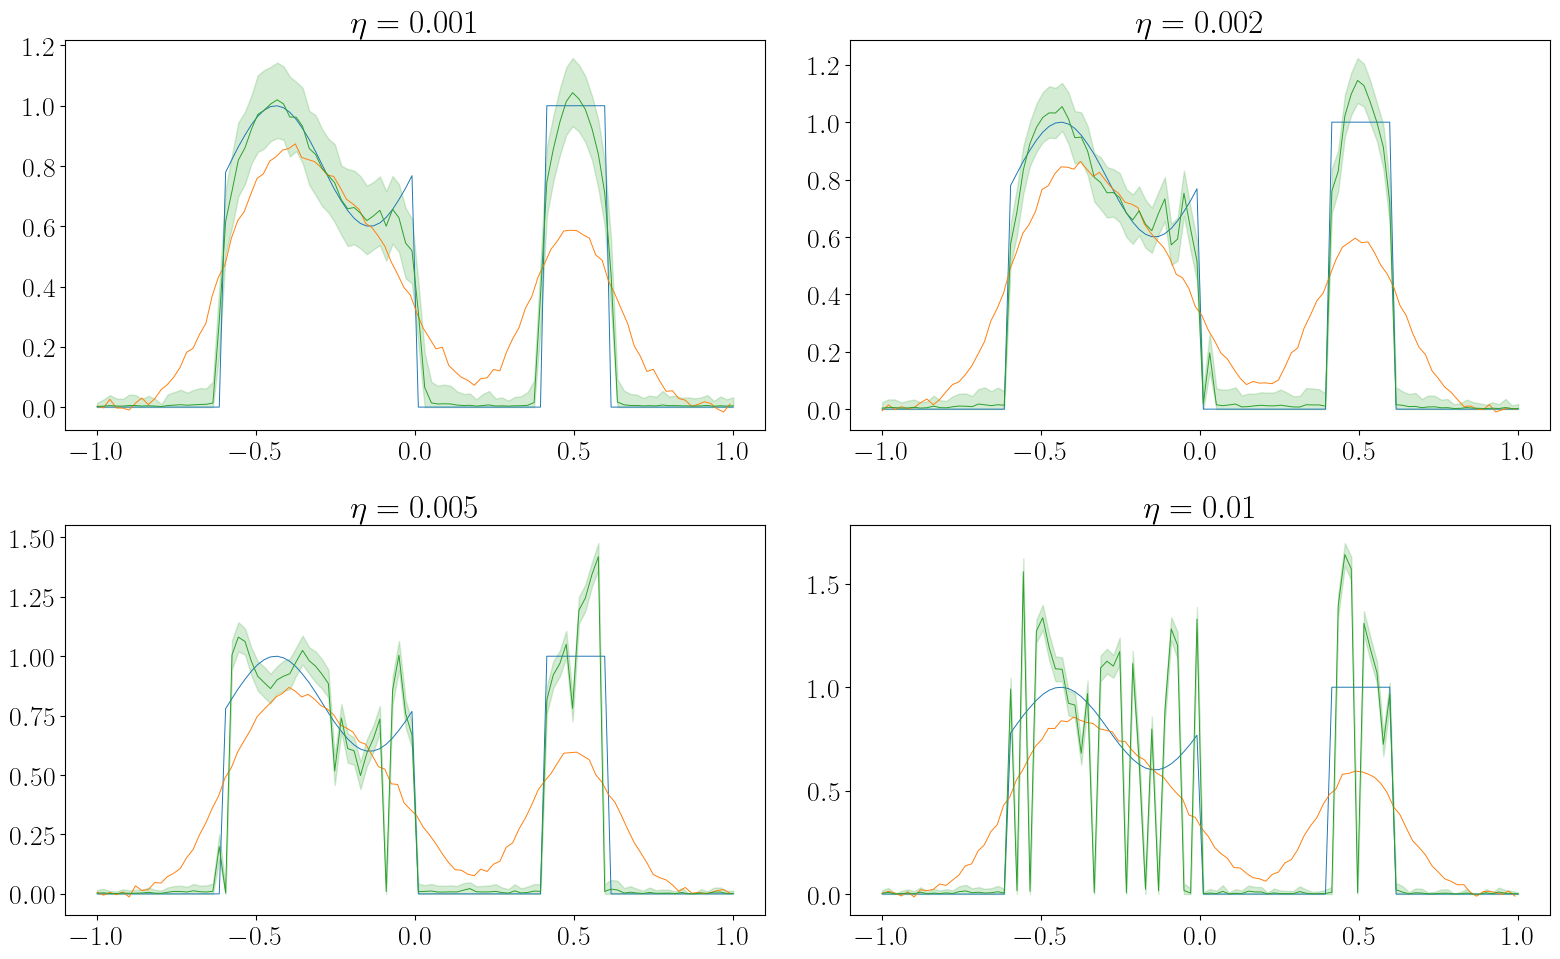

In [14]:
plot_lr_subplots(configs, 'learning_rate')

In [9]:
def f(xdata, theta):
    upper = theta[2] * (xdata[0]-theta[0])**2
    lower = theta[3] * (xdata[1]-theta[1])**2
    return np.array([theta[0], theta[1]]) + np.array([upper, lower])


def objective_function(theta, xdata, ydata):
    # Compute the predicted ydata using the model function
    y_pred = f(xdata, theta)
    
    # Calculate the squared differences between predicted and actual ydata
    residuals = y_pred - ydata
    squared_errors = residuals**2
    
    # Sum up all squared errors
    return np.sum(squared_errors)


from scipy.optimize import minimize

theta_0 = np.array([1., 1., 1., 1.])

theta_fitted = minimize(f, theta_0 ,xdata, ydata)

f(np.array([0., 0.]), np.array([1.0, 0.2, 0., -0.1]))

NameError: name 'xdata' is not defined